**1. Setup and load Data**

1.1 Install Dependencies and setup

In [ ]:
#!pip install tensorflow 

In [14]:
#!pip install matplotlib  

In [1]:
#!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [4]:
import tensorflow as tf
import os

In [5]:
#limit tensorflow using all the vram of gpu
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1.2 Remove dodgy images

In [23]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [24]:
data_dir='data'

In [25]:
os.listdir(data_dir)

['happy', 'sad']

In [26]:
image_exts=['jpeg','jpg','bmp','png']

In [27]:
img=cv2.imread(os.path.join('data','happy','Happiestpersonintheworld21.jpg'))

In [28]:
img.shape

(1968, 2497, 3)

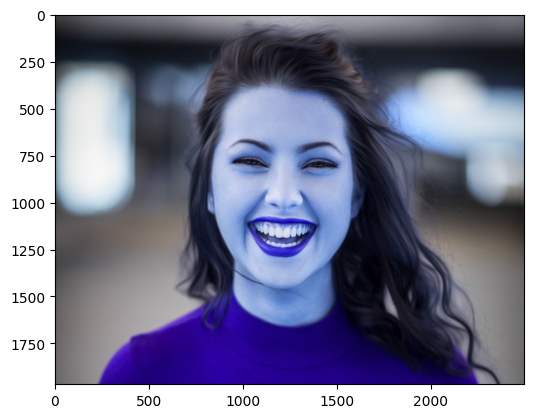

In [31]:
plt.imshow(img)

In [33]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path=os.path.join(data_dir, image_class,image)
        try:
            img= cv2.imread(image_path)
            tip= imghdr.what(image_path)
            if tip not in image_exts:
                print('Image is not ext list{}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
                print('Issues with image{}'.format(image.path))
                #os.remove(image_path)

Image is not ext listdata\happy\getty_152414899_97046097045006_68075.jpg
Image is not ext listdata\happy\Happy20People.jpg
Image is not ext listdata\sad\aaxh2l5ni.webp
Image is not ext listdata\sad\aHR0cHM6Ly9iLnN0YWJsZWNvZy5jb20vMWE5MGYyODMtYWI4ZC00ZTliLWE4MzYtNGZlYjQ3NDZhZWU3LmpwZWc.webp
Image is not ext listdata\sad\clip-art-seas-internet-scams-and-frauds-best-home-business-is-1713890451800.webp
Image is not ext listdata\sad\sad-man-and-rain-1330349202VkV.jpg
Image is not ext listdata\sad\sad-people-are-standing-rooftop-footage-092116870_iconl.jpeg
Image is not ext listdata\sad\spair-mental-person-sitting-in-dark-looking-dejected6629a96618e746.05218806.webp


1.3 Load Data

In [34]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None) -> 'DatasetV2'>

In [35]:
import numpy as np

In [137]:
data=tf.keras.utils.image_dataset_from_directory('data')

Found 177 files belonging to 2 classes.


In [138]:
data_iterator = data.as_numpy_iterator()

In [139]:
#get another batch from the iterator
batch=data_iterator.next()

In [140]:
#Images represented as numpy arrays (0: images/ 1:labels)
batch[0].shape

(32, 256, 256, 3)

In [141]:
#class 1 = sad people
#class 0= happy people
batch[1]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0], dtype=int32)

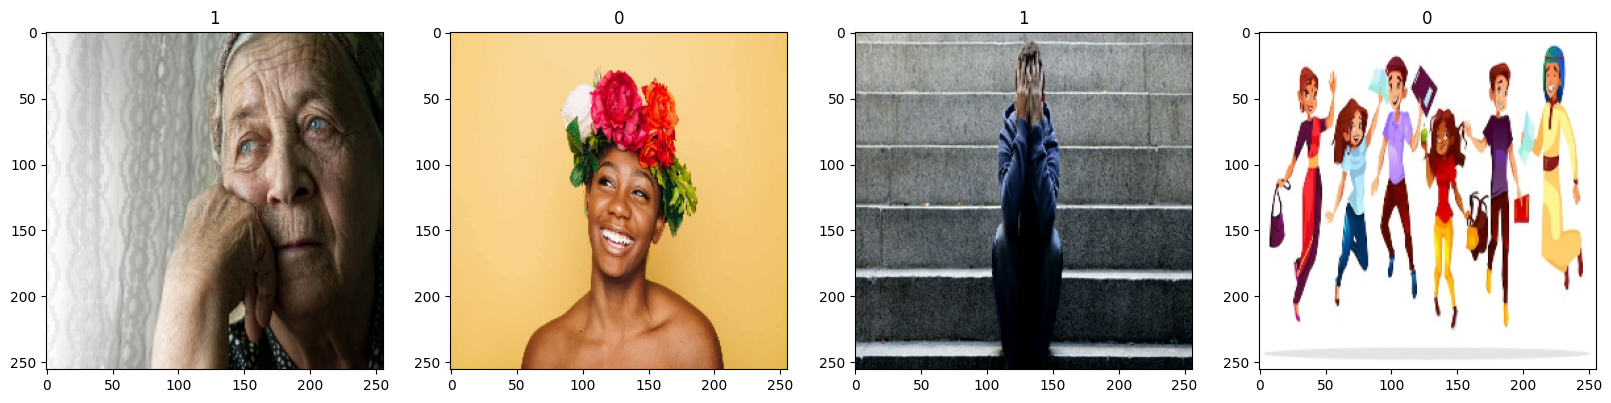

In [142]:
fig, ax= plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [143]:
print(batch[0].min())
print(batch[0].max())

0.0
255.0


**2. Preprocess Data**

2.1 Scale Data

In [144]:
data=data.map(lambda x, y: (x/255,y))

In [145]:
scaled_iterator=data.as_numpy_iterator()

In [146]:
batch= scaled_iterator.next()

In [147]:
batch[0].max()

np.float32(1.0)

2.2 Split Data

In [148]:
len(data)

6

In [149]:
train_size= int(len(data)* .6)
val_size= int(len(data)* .2)+1
test_size= int(len(data)* .1)+1


In [150]:
train= data.take(train_size)
val= data.skip(train_size).take(val_size)
test= data.skip(train_size+val_size).take(test_size)

**3. Deep Model**

3.1 Building Deep Learning Model

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [152]:
model=Sequential()

In [153]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


In [154]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [155]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

3.2 Train

In [156]:
logdir='logs'

In [157]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [158]:
hist=model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.5625 - loss: 1.1953 - val_accuracy: 0.4844 - val_loss: 0.7336
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.3867 - loss: 0.7549 - val_accuracy: 0.5625 - val_loss: 0.5967
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.5299 - loss: 0.6065 - val_accuracy: 0.7500 - val_loss: 0.5423
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 0.7539 - loss: 0.5470 - val_accuracy: 0.7812 - val_loss: 0.4868
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - accuracy: 0.8646 - loss: 0.4292 - val_accuracy: 0.8438 - val_loss: 0.4034
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step - accuracy: 0.7643 - loss: 0.4801 - val_accuracy: 0.8125 - val_loss: 0.3617
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 0.9076 - loss: 0.3091 - val_accuracy: 0.8906 - val_loss: 0.2824
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.9232 - loss: 0.2874 - val_accuracy: 0.8906 - val_loss:

3.3 Plot Performance

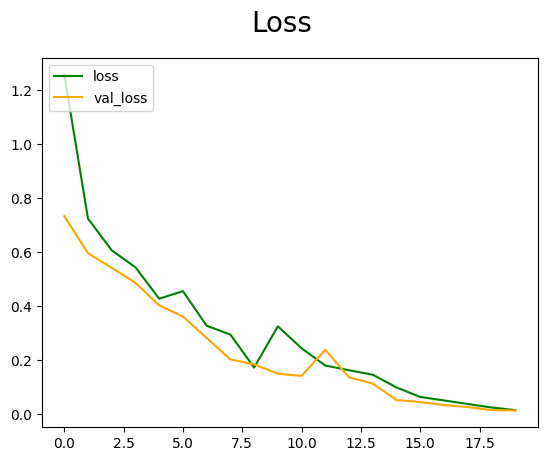

In [159]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='green',label = 'loss')
plt.plot(hist.history['val_loss'],color ='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

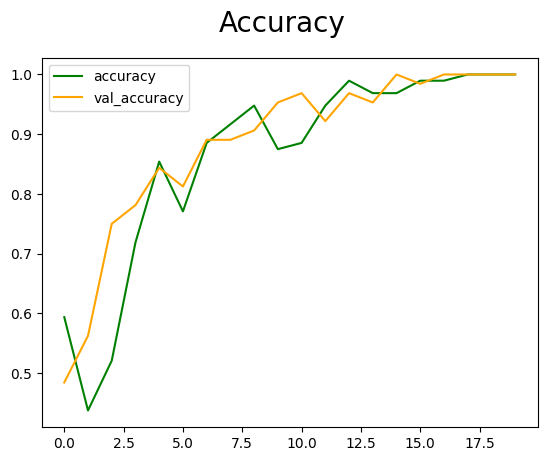

In [160]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='green',label = 'accuracy')
plt.plot(hist.history['val_accuracy'],color ='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

**4. Evaluate Performance**

4.1 Evaluate

In [161]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [162]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [163]:
for batch in test.as_numpy_iterator():
    X, y =batch
    yhat=model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [164]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


4.2 Test

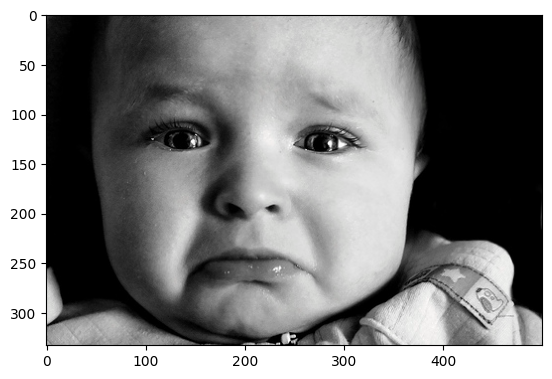

In [176]:
img=cv2.imread('newSad.jpg')
plt.imshow(img)
plt.show()

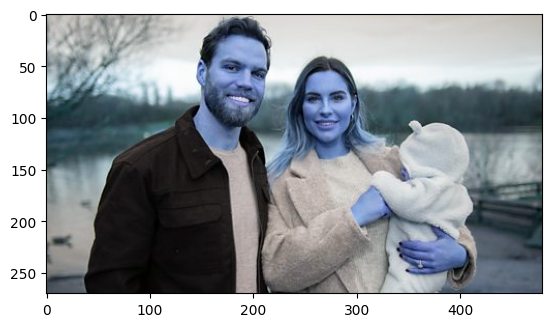

In [177]:
img2=cv2.imread('newHappy.jpg')
plt.imshow(img2)
plt.show()

In [203]:
resize=tf.image.resize(img, (256,256))


In [204]:
resize.shape


TensorShape([256, 256, 3])

In [205]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [206]:
yhat=model.predict(np.expand_dims(resize/255 ,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [207]:
yhat

array([[0.6424031]], dtype=float32)

In [208]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


**5. Save the Model**

In [190]:
from tensorflow.keras.models import load_model

In [191]:
model.save(os.path.join('models','HappySadModel.h5'))

In [192]:
new_model=load_model(os.path.join('models', 'HappySadModel.h5'))

In [213]:
resize=tf.image.resize(img2, (256,256))



In [216]:
yhatnew=new_model.predict(np.expand_dims(resize/255 ,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [217]:
if yhatnew > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')


Predicted class is Happy
